<a href="https://colab.research.google.com/github/umn-earth-surface/rainfall-runoff-board-game/blob/main/rainfall_runoff_geomorph2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rainfall-runoff visualization

This notebook utilizes components from the landscape evolution model Landlab (https://landlab.github.io/#/) to run a simple rainfall-runoff model. The model is based on the Rainfall-Runoff board game originally developed 
by Professor Andy Wickert, University of Minnesota Department of Earth and Environmental Sciences. It was converted into computer code by Jabari Jones, with a few edits from Andy Wickert.

## What is this notebook?

This notebook simulates the generation of runoff following a rainfall event in a landscape. Rather than using hydraulic equations, this game is based on rules that define how far water will move in a time step. For example, water in a river will move farther than water in the subsurface. 

This notebook can be paired with a lesson on unit hydrographs or flood generation.

## What will you do?

You will run each of the code blocks to generate a watershed made of hexagonal grid cells, set parameters for how the landscape transmits water, and then observe how water moves through the catchment after a spatially uniform rain storm. 

After answering a few questions, you will change some of the parameters in the code to investigate how changing watershed shape, size, subsurface storage, or rainfall pattern affect runoff. 

## How do I use this notebook?

To run each code block, click the play button in the top left corner of the block you'd like to run or press "shift", "enter" while you have that code block selected. Make sure you run the blocks in sequential order the first time. Comments start with a "#" sign and explain what the code below is doing. To edit the code block, simply click on it and change the code you would like. To run it again, click the play button.

## Now, onto the code

First, we'll import all the packages that we need to run the model and plot the results.

In [ ]:
#Code block 1

%%capture
import sys
!{sys.executable} -m pip install landlab
import matplotlib.pyplot as plt 
import numpy as np
from landlab import HexModelGrid
from landlab.plot import graph
from landlab.components import (FlowDirectorSteepest, FlowAccumulator)
from landlab.plot.drainage_plot import drainage_plot
from landlab.plot.imshow import imshow_grid_at_node

%matplotlib inline
#%matplotlib notebook # Set the plots to be interactive -- not supported by Google collab

## Building the model grid

The model will run on a hexagonal grid. Thankfully, Landlab has a built-in function to create hexagonal grids. Here we create a grid and plot it to see what it looks like.  

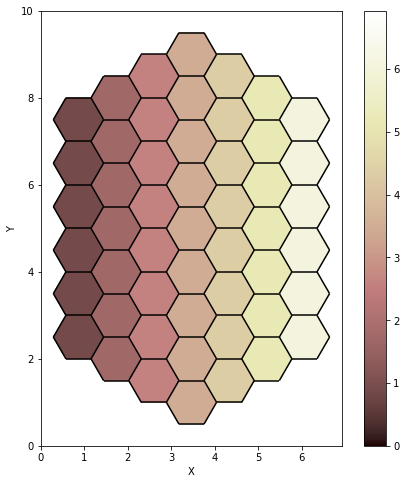

In [ ]:
#Code block 2

#create a grid
grid = HexModelGrid((7,9), orientation = 'vertical')

#plot the grid
fig = plt.figure(figsize = (8,8))
# The colorbar shows the x position of the grid nodes
imshow_grid_at_node(grid, grid.x_of_node, show_elements = True)


#Set parameters
Next we'll add attributes to the grid. These include:
1. Defining the type of cell, hillslope or river (which we'll add later)
2.Subsurface storage capacity
3. The total amount of water, surface water, and subsurface water in each cell
4. The distance from each cell to cell number 4, which will serve as the watershed outlet. Cells that are farther from the outlet are also assumed to be higher than the outlet, such that water will flow downhill to the outlet.


In [ ]:
#Code block 3

#create a cell type field for the grid that will be either hillslope or river, initially set all to hillslope
hillslope_array = np.full(grid.number_of_nodes, 'hillslope')
grid.add_field('cell_type', hillslope_array, at = 'node')

#Numeric version of the cell type for plotting purposes
grid.add_ones('numeric_cell', at = 'node')

#Define the subsurface storage capacity for every cell, 1 is the default
subsurface_array = np.full(grid.number_of_nodes, 1)
grid.add_field('subsurface_depth', subsurface_array, at = 'node')

#Create empty fields to track water
grid.add_zeros('water', at = 'node');
grid.add_zeros('surface_water', at = 'node')
grid.add_zeros('subsurface_water', at = 'node')

#calculate the distance to the outlet for every cell
dist = grid.calc_distances_of_nodes_to_point(grid.xy_of_node[0])
grid.add_field('distance', dist, at= 'node')

array([  0.        ,   1.        ,   1.        ,   2.        ,
         1.        ,   2.        ,   3.        ,   1.73205081,
         1.73205081,   3.        ,   4.        ,   2.64575131,
         2.        ,   2.64575131,   4.        ,   3.60555128,
         2.64575131,   2.64575131,   3.60555128,   4.58257569,
         3.46410162,   3.        ,   3.46410162,   4.58257569,
         4.35889894,   3.60555128,   3.60555128,   4.35889894,
         5.29150262,   4.35889894,   4.        ,   4.35889894,
         5.29150262,   5.19615242,   4.58257569,   4.58257569,
         5.19615242,   6.08276253,   5.29150262,   5.        ,
         5.29150262,   6.08276253,   6.08276253,   5.56776436,
         5.56776436,   6.08276253,   6.92820323,   6.244998  ,
         6.        ,   6.244998  ,   6.92820323,   7.        ,
         6.55743852,   6.55743852,   7.        ,   7.81024968,
         7.21110255,   7.        ,   7.21110255,   7.81024968,
         7.93725393,   7.54983444,   7.54983444,   7.93

Let's take another look at the grid, with labels for each node.

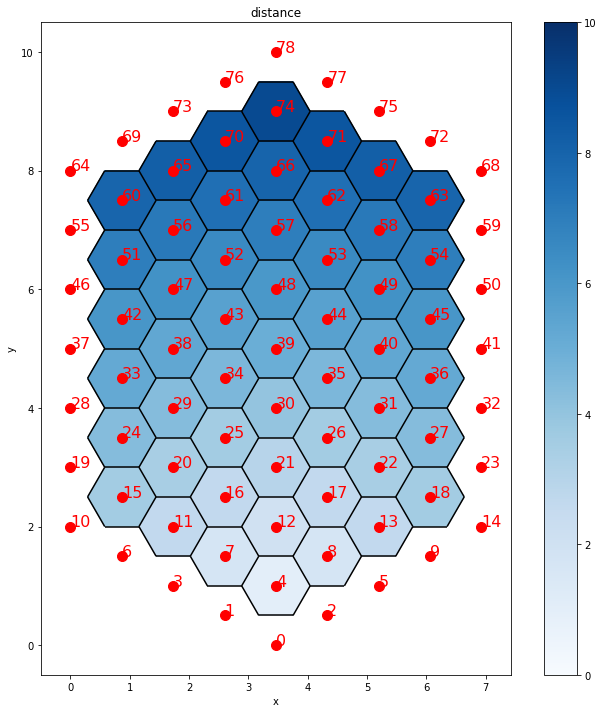

In [ ]:
#Code block 4

#plot the grid with the nodes labeled, so that we can choose them for the next section
fig = plt.figure(figsize = (12,12))
imshow_grid_at_node(grid, 'distance', cmap = 'Blues', show_elements = True)
graph.plot_graph(grid, at="node")

Now we need to choose the cells that will be river cells. We can do this by specifying cells in an array, and then changing the cell type of those grid nodes. And then we will decrease the 'elevation' of these cells to ensure that the Landlab flow routing algorithim properly routes flow between these cells.

Google's CoLab, on which this is running at the time of writing, does not support interactive plotting. So unforutnately, instead of being able to click on cells and turn them into "river", you will have to set the numbers (below). These should be connected to one another in order to be correct. Please ensure that you have a hydrologically reasonable watershed: think about contributing area and flow accumulation.

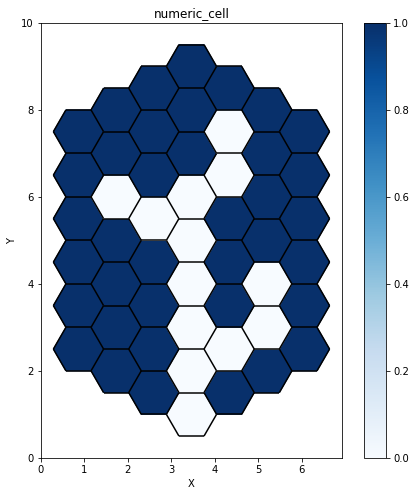

In [ ]:
#Code block 5

# Choose the cells that we want to be river cells.
# These should be connected to each other and to the outlet
# The final cell in the basin before the outlet must always be Cell 4:
# keep this in the array!
# The below set of stream cells is an example.
grid.at_node['cell_type'][:] = 'hillslope' # enable re-running of block alone
river_cells = np.array((4, 12, 21, 30, 17, 22, 31, 39, 43, 48, 53, 62, 47))
#river_cells = np.array([4, 12, 21, 30, 17, 22, 31, 39, 43, 47])
#river_cells = np.array([4])
grid.at_node['cell_type'][river_cells] = 'river'

# Recalculate distances to outlet
# This will allow you to update the grid in just this block
dist = grid.calc_distances_of_nodes_to_point(grid.xy_of_node[0])
grid.at_node['distance'] = dist

for i in grid.nodes:
  if grid.at_node['cell_type'][i] == 'river':
    grid.at_node['numeric_cell'][i] = 0
  else:
    grid.at_node['numeric_cell'][i] = 1
 
# Assume river cells are saturated, so they have 0 storage
# All others have a storage of 1 by default
grid.at_node['subsurface_depth'][river_cells] = 0

#lower the distance field for river cells to make flow routing work
#must be a better way to do this that will allow people to re-click this cell without consequence
grid.at_node['distance'][river_cells] = grid.at_node['distance'][river_cells] -0.5

#plot our grid with the river cells highlighted
fig = plt.figure(figsize = (8,8))
imshow_grid_at_node(grid, 'numeric_cell', cmap = 'Blues', show_elements = True)

Now we will use Landlab's flow-routing algorithim to define a flow network for our watershed:

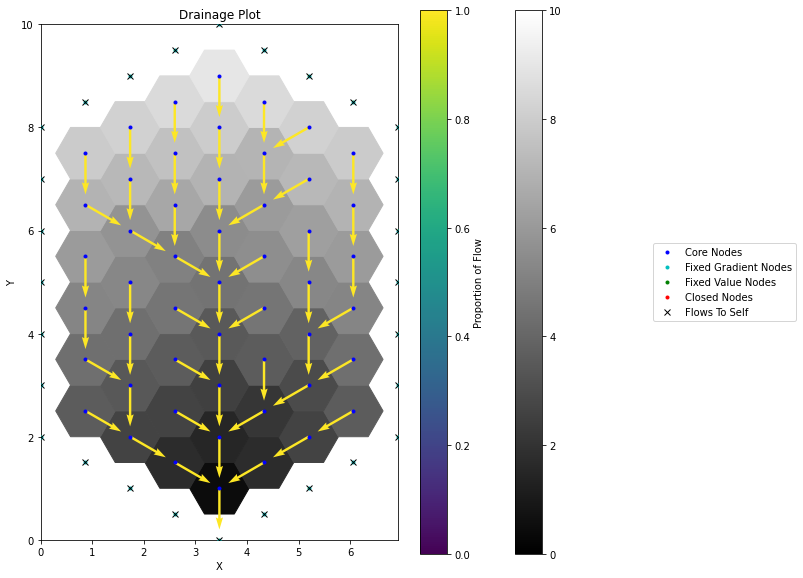

In [ ]:
#Code block 6

# Use Landlab's flow direction and flow routing algorithims
# Here, distance from the outlet is a virtual "elevation" to route flow.
flow_dir = FlowDirectorSteepest(grid, 'distance')
flow_dir.run_one_step()
receivers = flow_dir.direct_flow()
fa = FlowAccumulator(grid, surface = 'distance', flow_director = flow_dir)
fa.run_one_step()

#Plot the flow network
fig = plt.figure(figsize = (10,10))
drainage_plot(grid, surface = 'distance', receivers = receivers, proportions = None)

We see that the flow routing was successful - all the flow in the watershed is directed to the outlet, node 4.

The last thing we will do before we run the model is to set the amount of rain that will fall on the watershed. This should be an integer value.

In [ ]:
#Code block 7

# Define the amount of rain to be added to the watershed
rain = np.full(grid.number_of_nodes, 3)


# Model run
This next chunk is the heart of the model. 

For every timestep, we calculate how much water is in each cell and determine whether it is surface water or subsurface water. 

Water moves across the landscape according to the following rules:

*   Water in river cells moves 5 spaces
*   Surface water in hillslope cells initially moves 1 space, if it hits a river space, it moves 2 more (for a total of 3). If not, it moves one more (for a total of 2).
*   Subsurface water moves 1 space.

Take a moment to think about why this makes logical sense for our modeled landscape.

After moving the water, we re-calculate how much water is in each cell. We also calculate how much water is in the outlet cell to give the discharge at each timestep.

The produced plots do not have color bars, and are merely designed to show you the relative positions of the water in the landscape. Move on to the next step to see the hydrograph!

1 33 120.0
2 65.0 55.0
3 40.0 15.0
4 10.0 5.0
5 3.0 2.0
6 1.0 1.0
7 1.0 0.0


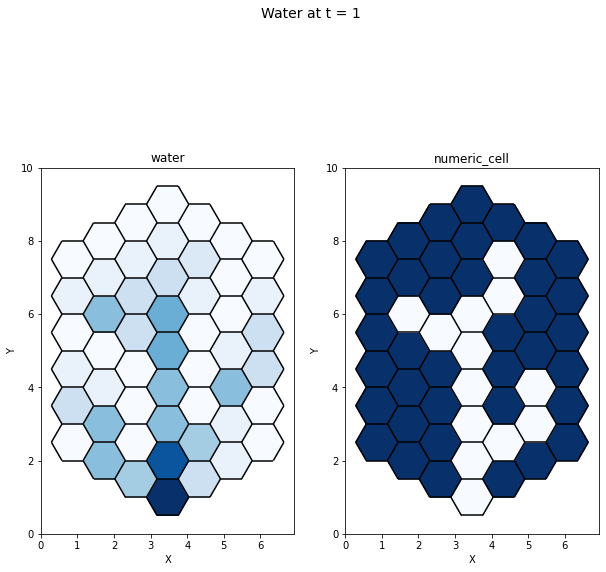

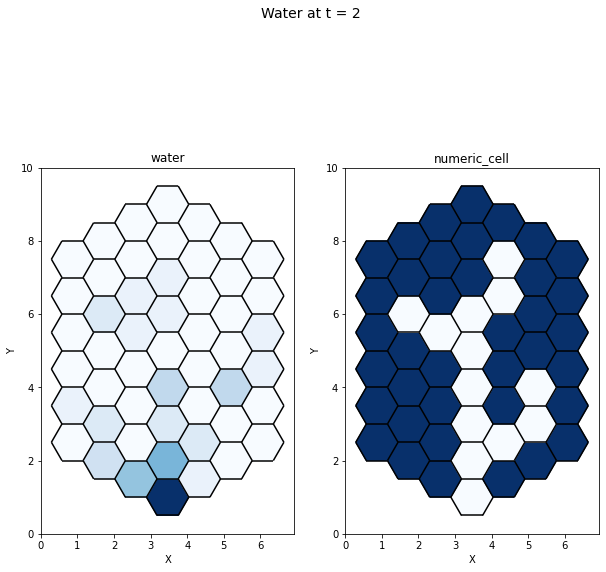

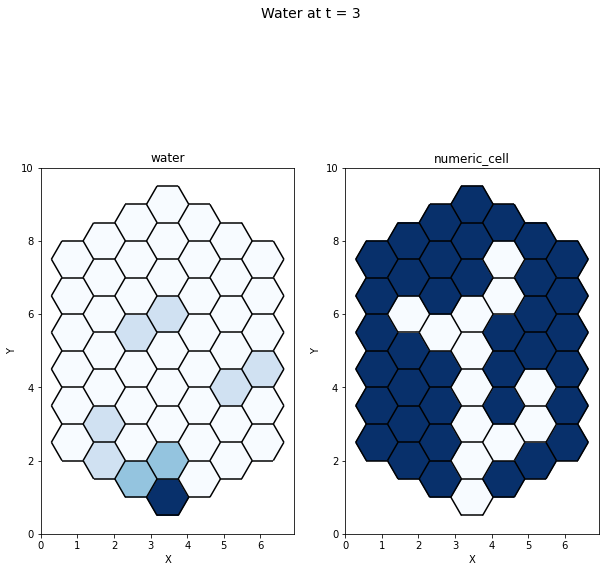

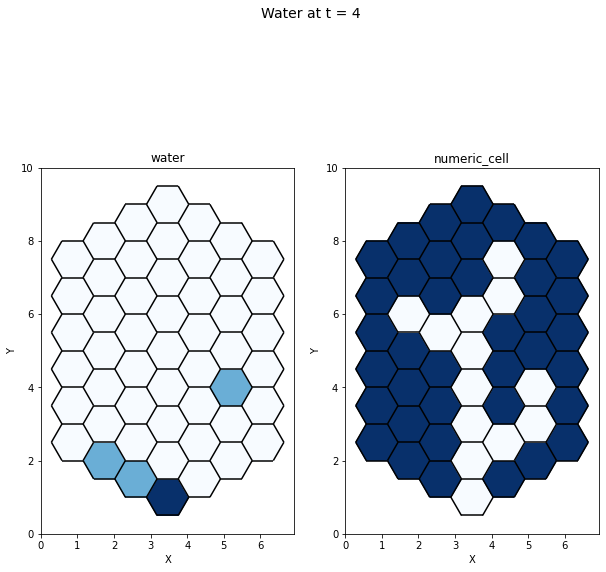

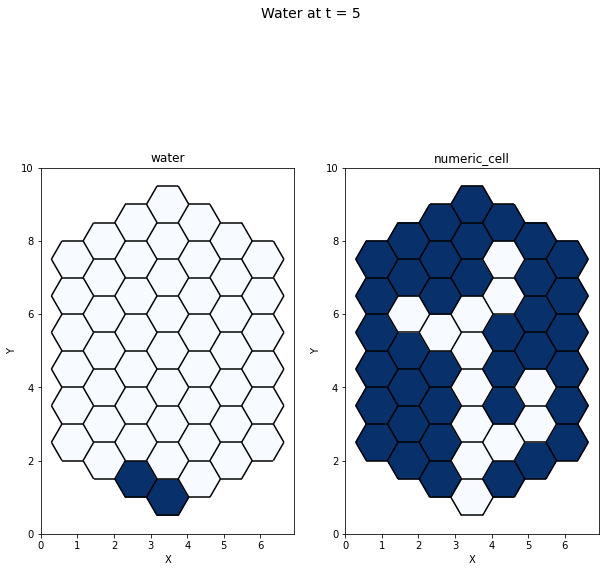

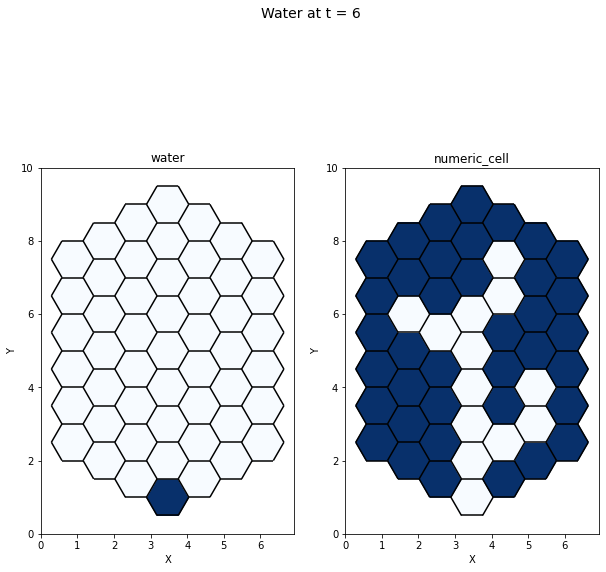

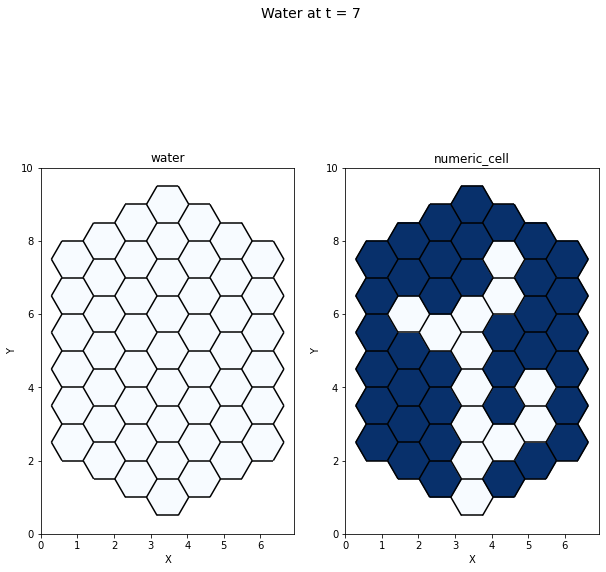

In [ ]:
#Code block 8

# Initialize water on watershed
grid.at_node['water'] = rain.copy()
#grid.at_node['water'][grid.boundary_nodes] = 0

#Initialize empty arrays that will store values during the model run
outlet_discharge = []

# Cells within the grid
nodes_at_cells = grid.nodes[ grid.cell_at_node != -1]

i = 0
while np.sum(grid.at_node['water']) > 0:
    i += 1
    #Reset reciving cells, timestep_water, and the amount of water at the outlet to zero 
    receiving_cells = []
    timestep_water = []
    #water_received_at_cell = np.zeros(len(grid.node_at_cell))
    water_received_at_cell = np.zeros(len(grid.nodes))

    timestep_Q = 0 # discharge during time step

    # Partition water into surface and subsurface
    grid.at_node['subsurface_water'] = grid.at_node['water']
    grid.at_node['surface_water'] = grid.at_node['subsurface_water'] - grid.at_node['subsurface_depth']
    grid.at_node['surface_water'][grid.at_node['surface_water'] < 0] = 0
    grid.at_node['subsurface_water'] -= grid.at_node['surface_water']

    #print('q', i, np.sum(grid.at_node['subsurface_water']) + np.sum(grid.at_node['surface_water']))

    # Find destination cells for water moving along the surface
    # or through the subsurface
    for l in nodes_at_cells:
      
        #Surface water routine
        if grid.at_node['surface_water'][l] > 0:
            # five steps in the river
            if grid.at_node['cell_type'][l] == 'river':
                # Could update into a recursive function or a loop
                move1 = grid.at_node['flow__receiver_node'][l]
                move2 = grid.at_node['flow__receiver_node'][move1]
                move3 = grid.at_node['flow__receiver_node'][move2]
                move4 = grid.at_node['flow__receiver_node'][move3]
                final_move = grid.at_node['flow__receiver_node'][move4]
            #Either two or three steps if on a hillslope cell 
            else:
                move1 = grid.at_node['flow__receiver_node'][l]
                if grid.at_node['cell_type'][move1] == 'river':
                    move2 = grid.at_node['flow__receiver_node'][move1]
                    final_move = grid.at_node['flow__receiver_node'][move2]
                else:
                    final_move = grid.at_node['flow__receiver_node'][move1]
        #if there is no surface water, it can't move to a new cell
        else:
            final_move = None
        
        #subsurface routine, only can move one cell          
        if grid.at_node['subsurface_water'][l] > 0:
            subsurface_move = grid.at_node['flow__receiver_node'][l]
        #if there is no subsurface water, it can't move to a new cell
        else:
            subsurface_move = None

        # Move water
        # Surface
        if final_move is not None:
            if final_move == 0:
                timestep_Q += grid.at_node['surface_water'][l]
            else:
                water_received_at_cell[grid.nodes == final_move] += grid.at_node['surface_water'][l]
        # Subsurface
        if subsurface_move is not None:
            # Should not be possible but might as well protect
            if final_move == 0:
                timestep_Q += grid.at_node['subsurface_water'][l]
            # This is what should happen all of the time
            else:
                #print(subsurface_move)
                water_received_at_cell[grid.nodes == subsurface_move] += grid.at_node['subsurface_water'][l]
    outlet_discharge.append(timestep_Q)
    print(i, timestep_Q, np.sum(water_received_at_cell))

    # Set the board for the next time step
    #print(water_received_at_cell)
    grid.at_node['water'] = water_received_at_cell

    ##################################
    #Plot water in each timestep
    title = 'Water at t ='
    title = title + ' ' + str(i)
    fig = plt.figure(figsize = (10,10))
    fig.suptitle(title, fontsize = 14)
    plt.subplot(121)
    imshow_grid_at_node(grid, 'water', cmap = 'Blues', show_elements = True, allow_colorbar = False, )
    plt.subplot(122)
    imshow_grid_at_node(grid, 'numeric_cell', cmap = 'Blues', show_elements = True, allow_colorbar = False)

Success (hopefully)! The plots above give us an idea of how water is moving through the landscape, with darker cells showing where there is more water. The hydrograph at the outlet is another tool to to get that information, and is typically what we would have in a real watershed.  

In [ ]:
#Create a plot of discharge at the outlet vs. time here. Remember that we have a variable that holds our timesteps and one that holds the discharge.

plt.figure()
# Insert your code here
plt.show()



<Figure size 432x288 with 0 Axes>

#Assignment

So, we've created a hexagonal watershed, passed a rainstorm over it, and tracked the water through the watershed. Let's look over the results to see what we've learned about runoff. 

**Question 1.** Plot the discharge at the watershed outlet using the empty code block above this text block. Plotting in Python can be tricky, but there is extensive documentation online. Be sure to include your code in the lab write-up.


###Changing parameters

Now you'll have the opportunity to change some parameters and see how that affects water transport across the landscape. Some options include:


*   Changing the drainage density (making more or fewer river tiles; remember to ensure that the drainage basin is hydrologically sensible)
*   Changing the drainage-basin shape or size
*   Changing the subsurface storage capacity
*   Changing the rainfall amount or spatial distribution

Choose two of these options (or others that you can think of). 

Before changing anything in the code, answer the following question:

**Question 2.** How do you think that altering these parameters will change flow through the watershed. In particular, how will the magnitude and timing of the peak flow be affected? 

In order to make these changes, you will need to alter parameters in one of the code blocks and re-run the script from Code block 2. Make sure to save any plots that illustrate your findings. 


**Question 3.** How did changing the parameters affect the movement of water? How do your observations compare to your predictions? 

**Question 4.** What are some simplifications that this model makes compared to a real watershed? How do you think those simplifications affect the peak and timing of river discharge? 